STEP 1: Downloading weekly adjusted close prices for assets...
Saved weekly asset prices to: asset_prices_weekly.csv

STEP 2: Building a robust Google Trends geopolitical risk proxy...


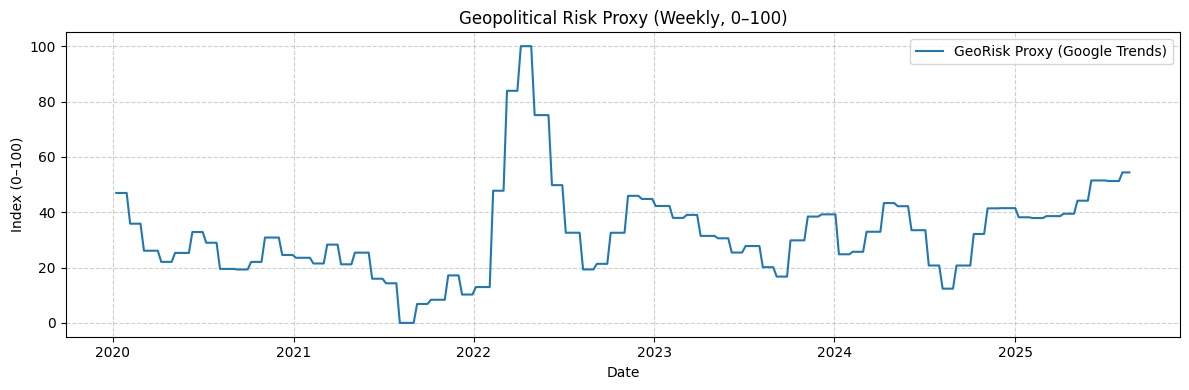

Saved asset prices with GeoRisk proxy to: asset_prices_with_georisk_proxy.csv

STEP 3: Running a simple regime-aware backtest...

=== Performance (Annualized) ===
Strategy | CAGR: 10.49%  Vol: 15.93%  Sharpe:  0.71  MDD: -23.92%
Buy&Hold | CAGR:  8.01%  Vol: 17.79%  Sharpe:  0.52  MDD: -33.47%


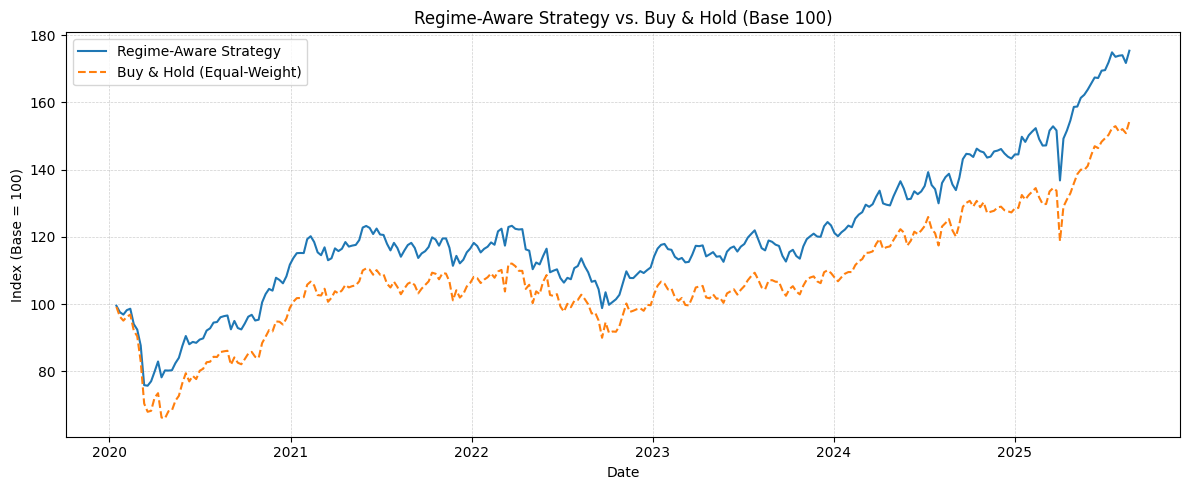


STEP 4: Adding transaction costs...

=== Performance Net of Costs (Annualized) ===
Strategy NET | CAGR: 10.33%  Vol: 15.92%  Sharpe:  0.70  MDD: -23.93%
Average Weekly Turnover: 0.027 (95th pct: 0.200)


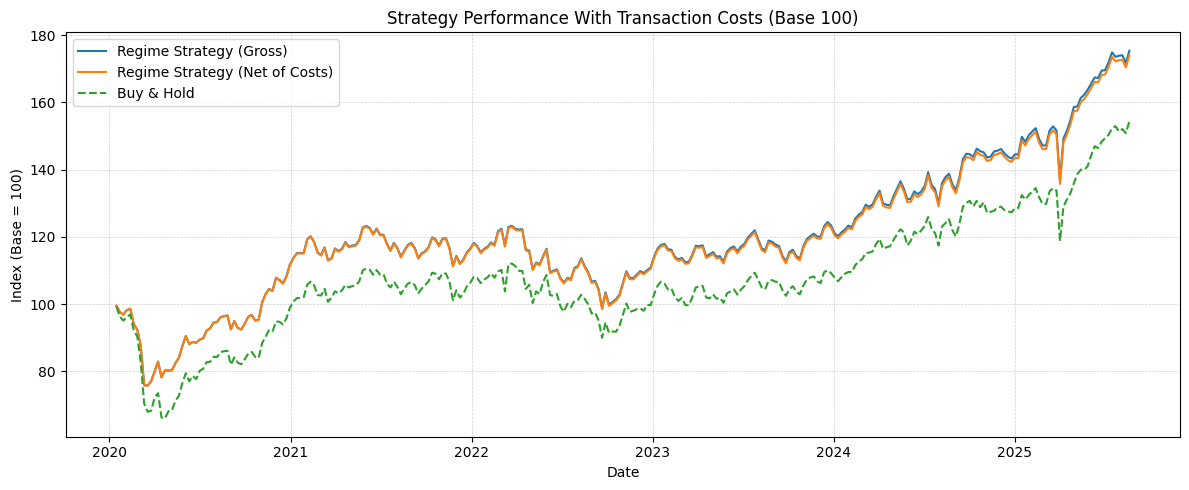


STEP 5: Building and backtesting a composite risk signal...

=== Composite Regime Performance (NET of costs) ===
CAGR: 10.37%  Vol: 16.06%  Sharpe: 0.70  MDD: -24.24%


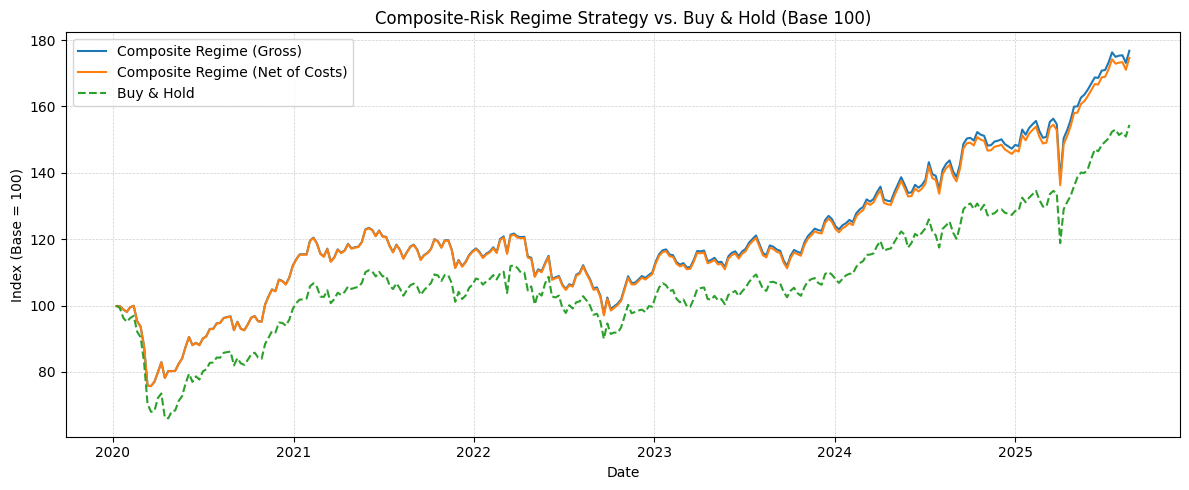


--- Backtest complete. ---


In [ ]:
import sys
import subprocess
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

warnings.filterwarnings("ignore")

def _ensure_package(package_name):
    try:
        __import__(package_name)
    except ImportError:
        print(f"Installing {package_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package_name])
        print(f"{package_name} installed.")

_ensure_package("yfinance")
_ensure_package("pytrends")

import yfinance as yf
from pytrends.request import TrendReq

ASSET_TICKERS = ['GLD', 'USO', 'XAR', 'EEM', 'VWO', 'IEMG']
RISK_TICKERS = {"VIX":"^VIX","OVX":"^OVX","TLT":"TLT","DXY":"DX-Y.NYB"}
START_DATE = "2020-01-01"
DATA_INTERVAL = "1wk"
TRANSACTION_COST_BPS = 0.001

def plot_base100(series_list, title):
    base = 100.0
    plt.figure(figsize=(12,5))
    for s, label, style in series_list:
        plt.plot(s.index, s.values*base, style, label=label)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Index (Base = 100)")
    plt.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Getting the Price Data

print("STEP 1: Downloading weekly adjusted close prices for assets...")

raw_prices = {t: yf.download(t, start=START_DATE, interval=DATA_INTERVAL,
                             auto_adjust=False, progress=False) for t in ASSET_TICKERS}

all_indices = [df.index for df in raw_prices.values()]
common_index = all_indices[0]
for idx in all_indices[1:]:
    common_index = common_index.union(idx)

price_series = {t: raw_prices[t]["Adj Close"].reindex(common_index) for t in ASSET_TICKERS}
prices = pd.concat(price_series, axis=1)
prices.columns = ASSET_TICKERS
prices.dropna(how="any", inplace=True)

prices.to_csv("asset_prices_weekly.csv")
print("Saved weekly asset prices to: asset_prices_weekly.csv")


# Building the Geopolitical Risk Proxy

print("\nSTEP 2: Building a robust Google Trends geopolitical risk proxy...")

pytrends = TrendReq(hl="en-US", tz=0)
georisk_keywords = ["geopolitics","war","sanctions","conflict","missile",
                    "terrorism","border tensions","NATO","invasion"]
keyword_batches = [georisk_keywords[i:i+5] for i in range(0, len(georisk_keywords), 5)]

tf_start = prices.index.min().strftime('%Y-%m-%d')
tf_end   = prices.index.max().strftime('%Y-%m-%d')
timeframe = f"{tf_start} {tf_end}"

def fetch_google_trends(timeframe_to_fetch):
    trend_data_frames = []
    for batch in keyword_batches:
        ok = False
        for _ in range(3):
            try:
                pytrends.build_payload(batch, timeframe=timeframe_to_fetch, geo="", cat=0, gprop="")
                df = pytrends.interest_over_time()
                if df is not None and not df.empty:
                    ok = True
                    break
            except Exception:
                pass
            sleep(0.6)
        if not ok:
            continue
        if "isPartial" in df.columns:
            df = df.drop(columns=["isPartial"])
        df = df.apply(pd.to_numeric, errors="coerce")
        trend_data_frames.append(df)
        sleep(0.4)
    return trend_data_frames

trend_frames = fetch_google_trends(timeframe)
if not trend_frames:
    print("Warning: PyTrends empty for exact window. Falling back to 'today 5-y'.")
    trend_frames = fetch_google_trends("today 5-y")
if not trend_frames:
    raise RuntimeError("Critical: Google Trends returned no data after retries.")

gtr = pd.concat(trend_frames, axis=1, join="outer").sort_index().dropna(how="all")

for col in gtr.columns:
    mn, mx = gtr[col].min(), gtr[col].max()
    if pd.notna(mn) and pd.notna(mx) and (mx - mn) > 0:
        gtr[col] = 100 * (gtr[col] - mn) / (mx - mn)

gpr_daily  = gtr.mean(axis=1, skipna=True).rolling(3, min_periods=1).mean()
gpr_weekly = gpr_daily.resample("W").mean().ffill().bfill()
gpr_weekly = gpr_weekly.reindex(prices.index, method="pad")

if gpr_weekly.isna().all() or (gpr_weekly.max() - gpr_weekly.min()) < 1e-9:
    print("Warning: GeoRisk proxy flat/NaN. Using fallback volatility proxy.")
    fallback = prices.pct_change().rolling(8).std()[['USO','EEM']].mean(axis=1)
    fallback = fallback.reindex(prices.index).bfill().ffill()
    gpr_weekly = 100 * (fallback - fallback.min()) / (fallback.max() - fallback.min() + 1e-12)
else:
    mn, mx = gpr_weekly.min(), gpr_weekly.max()
    gpr_weekly = 100 * (gpr_weekly - mn) / (mx - mn + 1e-12)

plt.figure(figsize=(12,4))
plt.plot(gpr_weekly.index, gpr_weekly.values, label="GeoRisk Proxy (Google Trends)")
plt.title("Geopolitical Risk Proxy (Weekly, 0–100)")
plt.xlabel("Date"); plt.ylabel("Index (0–100)")
plt.grid(True, linestyle='--', alpha=0.6); plt.legend(); plt.tight_layout(); plt.show()

combined_data = prices.copy()
combined_data["GeoRisk_Proxy"] = gpr_weekly
combined_data.to_csv("asset_prices_with_georisk_proxy.csv")
print("Saved asset prices with GeoRisk proxy to: asset_prices_with_georisk_proxy.csv")


# Backtesting the Simple Regime Strategy

print("\nSTEP 3: Running a simple regime-aware backtest...")

returns = prices.pct_change().dropna()
risk_assets = ['USO', 'EEM']
market_thermometer = returns[risk_assets].rolling(8).std().mean(axis=1).reindex(returns.index).ffill()

def z_score(series):
    return (series - series.mean()) / (series.std(ddof=0) + 1e-12)

risk_signal = z_score(gpr_weekly.reindex(returns.index)) + z_score(market_thermometer)
hi = risk_signal.quantile(0.60); lo = risk_signal.quantile(0.40)

regime = pd.Series("Neutral", index=risk_signal.index)
regime[risk_signal <= lo] = "Calm"
regime[risk_signal >= hi] = "Stress"

weights_calm    = pd.Series({'GLD':0.15,'USO':0.10,'XAR':0.20,'EEM':0.20,'VWO':0.20,'IEMG':0.15})
weights_stress  = pd.Series({'GLD':0.40,'USO':0.05,'XAR':0.30,'EEM':0.10,'VWO':0.10,'IEMG':0.05})
weights_neutral = pd.Series({'GLD':0.25,'USO':0.08,'XAR':0.25,'EEM':0.15,'VWO':0.15,'IEMG':0.12})

weights = pd.DataFrame(index=returns.index, columns=ASSET_TICKERS)
weights[regime=="Calm"]    = weights_calm.reindex(ASSET_TICKERS).values
weights[regime=="Stress"]  = weights_stress.reindex(ASSET_TICKERS).values
weights[regime=="Neutral"] = weights_neutral.reindex(ASSET_TICKERS).values
weights = weights.shift(1).dropna()

aligned_returns = returns.loc[weights.index]
strategy_returns = (weights * aligned_returns).sum(axis=1)
buy_and_hold_returns = (aligned_returns * (1/len(ASSET_TICKERS))).sum(axis=1)

cumulative_strategy     = (1 + strategy_returns).cumprod()
cumulative_buy_and_hold = (1 + buy_and_hold_returns).cumprod()

def performance_stats(returns, risk_free_rate=0.0):
    ann = 52
    cagr  = (1 + returns).prod()**(ann/len(returns)) - 1
    vol   = returns.std(ddof=0) * np.sqrt(ann)
    sharpe= (returns.mean()*ann - risk_free_rate) / (vol + 1e-12)
    mdd   = ((1+returns).cumprod().div((1+returns).cumprod().cummax())-1).min()
    return cagr, vol, sharpe, mdd

strat_cagr,strat_vol,strat_sharpe,strat_mdd = performance_stats(strategy_returns)
bh_cagr,bh_vol,bh_sharpe,bh_mdd = performance_stats(buy_and_hold_returns)

print("\n=== Performance (Annualized) ===")
print(f"Strategy | CAGR: {strat_cagr:6.2%}  Vol: {strat_vol:6.2%}  Sharpe: {strat_sharpe:5.2f}  MDD: {strat_mdd:6.2%}")
print(f"Buy&Hold | CAGR: {bh_cagr:6.2%}  Vol: {bh_vol:6.2%}  Sharpe: {bh_sharpe:5.2f}  MDD: {bh_mdd:6.2%}")

plot_base100(
    [(cumulative_strategy, "Regime-Aware Strategy", "-"),
     (cumulative_buy_and_hold, "Buy & Hold (Equal-Weight)", "--")],
    "Regime-Aware Strategy vs. Buy & Hold (Base 100)"
)


#Factoring in Transaction Costs

print("\nSTEP 4: Adding transaction costs...")

delta_weights = (weights - weights.shift(1)).fillna(0.0)
turnover = 0.5 * delta_weights.abs().sum(axis=1)
transaction_costs = TRANSACTION_COST_BPS * turnover
strategy_returns_net = strategy_returns - transaction_costs

cumulative_strategy_net = (1 + strategy_returns_net).cumprod()

net_cagr, net_vol, net_sharpe, net_mdd = performance_stats(strategy_returns_net)
print("\n=== Performance Net of Costs (Annualized) ===")
print(f"Strategy NET | CAGR: {net_cagr:6.2%}  Vol: {net_vol:6.2%}  Sharpe: {net_sharpe:5.2f}  MDD: {net_mdd:6.2%}")
print(f"Average Weekly Turnover: {turnover.mean():.3f} (95th pct: {turnover.quantile(0.95):.3f})")

plot_base100(
    [(cumulative_strategy, "Regime Strategy (Gross)", "-"),
     (cumulative_strategy_net, "Regime Strategy (Net of Costs)", "-"),
     (cumulative_buy_and_hold, "Buy & Hold", "--")],
    "Strategy Performance With Transaction Costs (Base 100)"
)


# Testing a Composite Risk Signal

print("\nSTEP 5: Building and backtesting a composite risk signal...")

risk_prices = {}
for name, ticker in RISK_TICKERS.items():
    try:
        df = yf.download(ticker, start=prices.index.min().strftime("%Y-%m-%d"),
                         end=prices.index.max().strftime("%Y-%m-%d"),
                         interval=DATA_INTERVAL, auto_adjust=False, progress=False)
        if not df.empty:
            col = "Adj Close" if "Adj Close" in df.columns else "Close"
            s = df[col].copy()
            s.name = name
            risk_prices[name] = s
        else:
            print(f"Warning: No data for {name} ({ticker}).")
    except Exception as e:
        print(f"Failed to download {name} ({ticker}): {e}")

risk_df = pd.DataFrame(index=prices.index)
if risk_prices:
    risk_df = pd.concat(risk_prices.values(), axis=1)
    if isinstance(risk_df.columns, pd.MultiIndex):
        risk_df.columns = risk_df.columns.get_level_values(0)
    risk_df = risk_df.reindex(prices.index).ffill().bfill()
else:
    print("Warning: No additional risk data downloaded.")

def realized_vol_z(series, window=8):
    if isinstance(series, pd.DataFrame):
        series = series.iloc[:, 0] if series.shape[1] == 1 else series.mean(axis=1)
    if series.empty:
        return pd.Series(0.0, index=prices.index)
    r = series.pct_change()
    vol = r.rolling(window).std()
    return z_score(vol).reindex(prices.index).ffill()

risk_components = []
if "VIX" in risk_df.columns: risk_components.append(z_score(risk_df["VIX"]))
if "OVX" in risk_df.columns: risk_components.append(z_score(risk_df["OVX"]))
if "TLT" in risk_df.columns: risk_components.append(realized_vol_z(risk_df["TLT"]))
if "DXY" in risk_df.columns: risk_components.append(realized_vol_z(risk_df["DXY"]))
risk_components.append(z_score(market_thermometer).reindex(prices.index).ffill())
risk_components.append(z_score(gpr_weekly).reindex(prices.index).ffill())

risk_components = [c.astype(float).reindex(prices.index).ffill().bfill() for c in risk_components]

composite_signal = pd.concat(risk_components, axis=1).mean(axis=1)

hi2 = composite_signal.quantile(0.60); lo2 = composite_signal.quantile(0.40)
composite_regime = pd.Series("Neutral", index=composite_signal.index)
composite_regime[composite_signal <= lo2] = "Calm"
composite_regime[composite_signal >= hi2] = "Stress"

weights_c = pd.DataFrame(index=prices.index, columns=ASSET_TICKERS)
weights_c[composite_regime=="Calm"]    = weights_calm.reindex(ASSET_TICKERS).values
weights_c[composite_regime=="Stress"]  = weights_stress.reindex(ASSET_TICKERS).values
weights_c[composite_regime=="Neutral"] = weights_neutral.reindex(ASSET_TICKERS).values
weights_c = weights_c.shift(1).dropna()

aligned_returns_comp = prices.pct_change().dropna().loc[weights_c.index]
gross_comp = (weights_c * aligned_returns_comp).sum(axis=1)
turn_comp  = 0.5 * weights_c.diff().abs().sum(axis=1).fillna(0.0)
costs_comp = turn_comp * TRANSACTION_COST_BPS
net_comp   = gross_comp - costs_comp

cum_gross_comp = (1 + gross_comp).cumprod()
cum_net_comp   = (1 + net_comp).cumprod()
bh_comp        = (aligned_returns_comp * (1/len(ASSET_TICKERS))).sum(axis=1)
cum_bh_comp    = (1 + bh_comp).cumprod()

comp_cagr, comp_vol, comp_sharpe, comp_mdd = performance_stats(net_comp)
print("\n=== Composite Regime Performance (NET of costs) ===")
print(f"CAGR: {comp_cagr:.2%}  Vol: {comp_vol:.2%}  Sharpe: {comp_sharpe:.2f}  MDD: {comp_mdd:.2%}")

plot_base100(
    [(cum_gross_comp, "Composite Regime (Gross)", "-"),
     (cum_net_comp,   "Composite Regime (Net of Costs)", "-"),
     (cum_bh_comp,    "Buy & Hold", "--")],
    "Composite-Risk Regime Strategy vs. Buy & Hold (Base 100)"
)

print("\n--- Backtest complete. ---")

In [ ]:
v